In [1]:
import os
import copy
import glob

import numpy as np
from scipy.interpolate import interp1d,splev,splrep
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import astropy.modeling
from sunpy.map import Map

from synthesizAR.instruments import InstrumentHinodeEIS
from synthesizAR.util import EISCube
from synthesizAR.atomic import EmissionModel

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


# Doppler Shifts in EIS Line Profiles
Analyze emission line profiles as a function of velocity and time for selected portions of the AR.

From our emission measure analysis notebook and Warren et al. (2012), we know we want to look at the following location in AR 1109:

In [2]:
left_x = 350*u.arcsec
bottom_y = 265*u.arcsec
width = 20*u.arcsec
height = 15*u.arcsec
right_x = left_x + width
top_y = bottom_y + height

## Emission Model

In [3]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/',
                                       load_emissivity=False)

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

Select the transitions we want to look at.

In [4]:
for i,ion in enumerate(emission_model.ions):
    if len(ion.resolved_wavelengths) > 0:
        print(i,ion.chianti_ion.meta['name'])

65 s_13
69 ca_17
84 si_10
88 ar_14
90 ca_16
110 ca_15
126 s_10
130 ca_14
143 si_7
200 fe_16
211 fe_15
216 fe_14
223 fe_13
230 fe_12
238 fe_11
242 fe_10
246 fe_9


Fe XII 195.119 angstrom line, a cooler line.

In [5]:
emission_model.ions[230].resolved_wavelengths

<Quantity [ 192.394, 195.119] Angstrom>

Ca XVII 192.8532 angstrom line, a hotter line

In [6]:
emission_model.ions[69].resolved_wavelengths

<Quantity [ 192.8532] Angstrom>

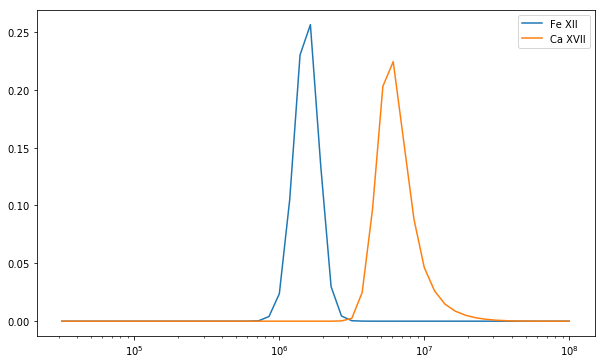

In [141]:
plt.figure(figsize=(10,6))
plt.plot(emission_model.temperature_mesh[:,0],emission_model.ions[230].fractional_ionization[:,0],label=r'Fe XII')
plt.plot(emission_model.temperature_mesh[:,0],emission_model.ions[69].fractional_ionization[:,0],label=r'Ca XVII')
plt.legend()
plt.xscale('log')

In [7]:
transitions = [emission_model.ions[230].resolved_wavelengths[1],
               emission_model.ions[69].resolved_wavelengths[0]]

## Load Data and Fit
Load in the cube, slice in wavelength space to desired lines, average over desired spatial area for each timestep.

In [15]:
eis_file_template = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_{frequency}_frequency/Hinode_EIS/{channel}/map_t{i_time:06d}.h5'

In [16]:
eis = InstrumentHinodeEIS([7.5e3,1e4]*u.s)

Store the time dependent profiles as NumPy arrays in dictionaries

In [17]:
fitted_profiles = {freq:{t:{'intensity':np.empty((eis.observing_time.shape[0],200)),
                            'mean':np.empty(eis.observing_time.shape),
                            'width':np.empty(eis.observing_time.shape)} 
                         for t in transitions} 
                   for freq in ['high','intermediate','low']}

Read in data

In [18]:
for i,_ in enumerate(eis.observing_time):
    print(i)
    for freq in ['high','intermediate','low']:
        # read cube file
        # note that we can only select the first channel because both lines come from here
        tmp = EISCube(eis_file_template.format(frequency=freq,channel=eis.channels[0]['name'],i_time=i+750))
        interpolated_wavelengths = {}
        for t in transitions:
            i_wave = np.argwhere(np.isclose(tmp.wavelength.value,t.value,rtol=0.0,atol=1.1e-2))
            tmp_spec = (tmp[i_wave-10:i_wave+10]
                        .submap(u.Quantity([left_x,right_x]),u.Quantity([bottom_y,top_y]))
                        .data.mean(axis=(0,1)))
            # save interpolated wavelengths
            interpolated_wavelengths[t] = np.linspace(tmp[i_wave-10:i_wave+10].wavelength.value.min(),
                                                      tmp[i_wave-10:i_wave+10].wavelength.value.max(),200)
            # fit to Gaussian
            m_init = astropy.modeling.models.Gaussian1D(mean=t.value,
                                                        amplitude=tmp_spec.max(),
                                                        stddev=(interpolated_wavelengths[t][-1]-interpolated_wavelengths[t][0])/10.)
            fitter = astropy.modeling.fitting.LevMarLSQFitter()
            m_fit = fitter(m_init,tmp.wavelength[i_wave-10:i_wave+10].value,tmp_spec)
            # store
            fitted_profiles[freq][t]['intensity'][i,:] = m_fit(interpolated_wavelengths[t])
            fitted_profiles[freq][t]['mean'][i] = m_fit.mean.value
            fitted_profiles[freq][t]['width'][i] = m_fit.stddev.value

0


/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:1023: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  out = super(Quantity, self).__getitem__(key)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


## Plotting

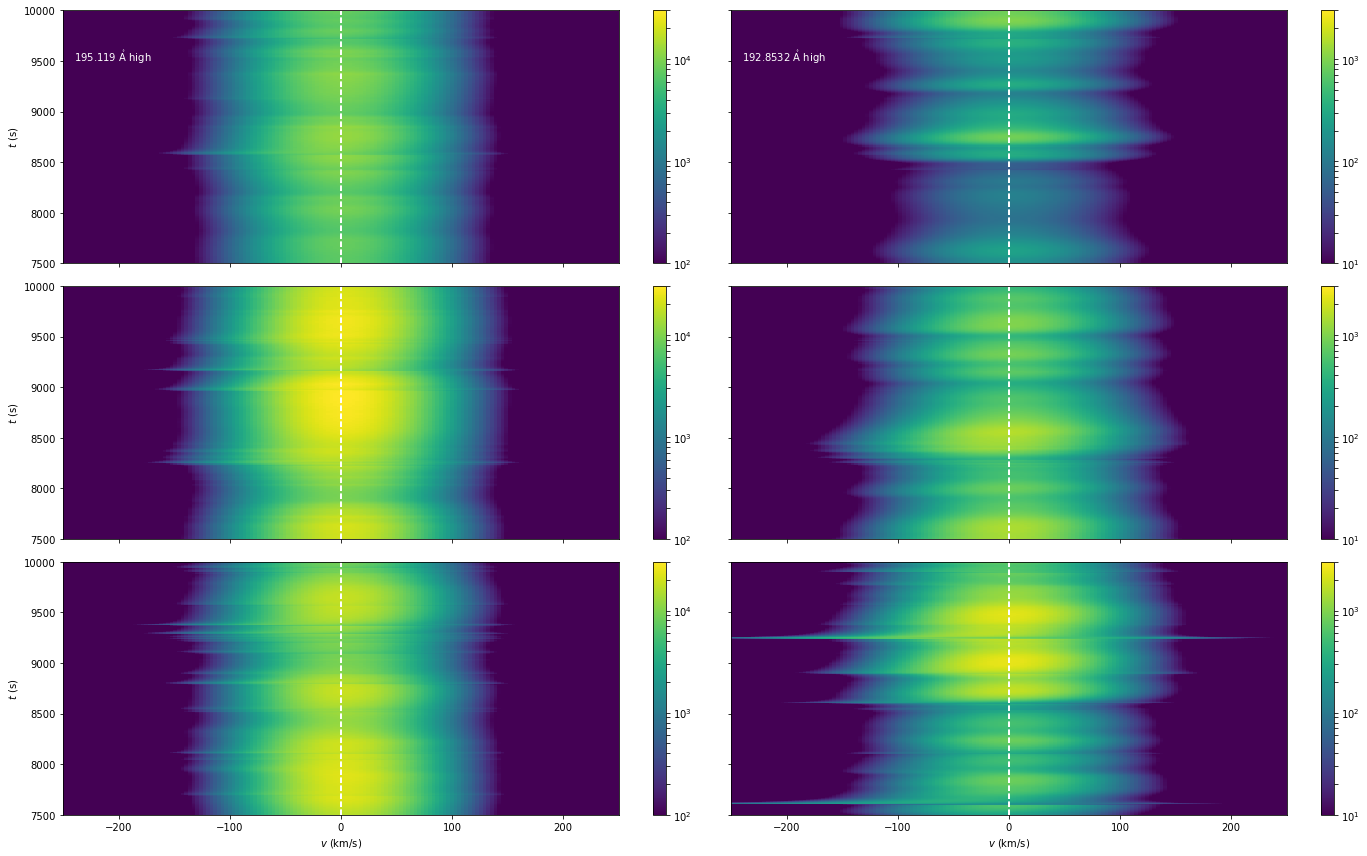

In [144]:
fig,axes = plt.subplots(3,2,figsize=(20,12),sharey=True,sharex=True)
for j,freq in enumerate(['high','intermediate','low']):
    for i,(t,vb) in enumerate(zip(transitions,[(1e2,3e4),(1e1,3e3)])):
        wavelength_mesh,time_mesh = np.meshgrid((const.c.to(u.km/u.s)*(interpolated_wavelengths[t]/t.value - 1.)).value,
                                                eis.observing_time.value)
        im = axes[j,i].pcolormesh(wavelength_mesh,time_mesh,
                                  fitted_profiles[freq][t]['intensity'],
                                  norm=matplotlib.colors.SymLogNorm(1,vmin=vb[0],vmax=vb[1])
                                  #vmin=vb[0],vmax=vb[1],
                                 )
        axes[j,i].axvline(x=0.0,ls='--',color='w',lw=2)
        if j==0:
            axes[0,i].text(-240,9500,r'{} {:latex} {}'.format(t.value,t.unit,freq),color='w')
        if j==2:
            axes[-1,i].set_xlabel(r'$v$ (km/s)')
        fig.colorbar(im,ax=axes[j,i])
    axes[j,0].set_ylabel(r'$t$ (s)')
axes[0,0].set_ylim([7500,1e4])
axes[0,0].set_xlim([-250,250])
plt.tight_layout()

#plt.subplots_adjust(hspace=0.0,wspace=0.0)
#fig.colorbar(im,ax=axes[i])

Plot the width of the line, i.e. the second moment of the line.

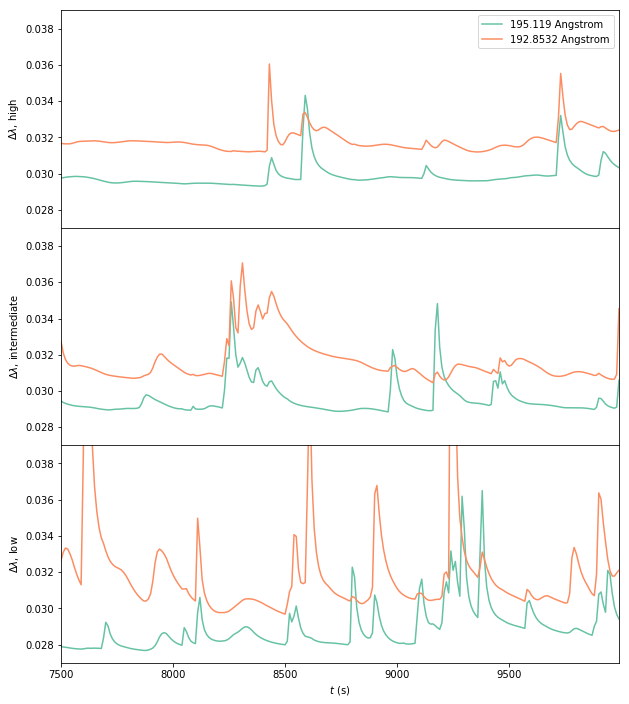

In [96]:
fig,axes = plt.subplots(3,1,figsize=(10,12),sharex=True,sharey=True)
for freq,ax in zip(['high','intermediate','low'],axes.flatten()):
    for color,t in zip(sns.color_palette('Set2'),transitions):
        ax.plot(eis.observing_time,fitted_profiles[freq][t]['width'],
                ls='-',label='{}'.format(t),color=color)
    ax.set_ylabel(r'$\Delta\lambda$, {}'.format(freq))
        
axes[0].legend(loc='best')
axes[-1].set_xlabel(r'$t$ (s)')
axes[0].set_xlim([eis.observing_time[0].value,eis.observing_time[-1].value])
axes[0].set_ylim([0.027,0.039])
plt.subplots_adjust(hspace=0)
#plt.yscale('log')

Plot the mean, i.e. the deviation from the rest wavelength, as a function of time. This is the first moment of the line.

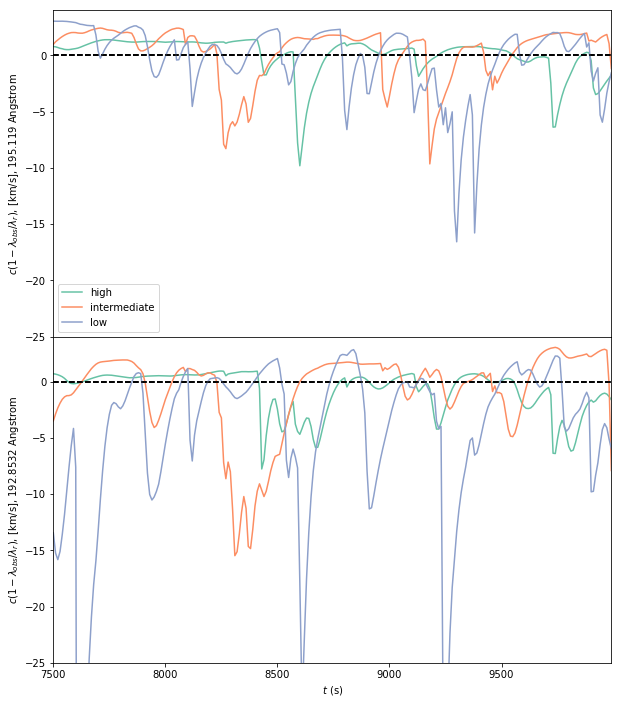

In [151]:
fig,axes = plt.subplots(2,1,figsize=(10,12),sharex=True,sharey=True)
for t,ax in zip(transitions,axes.flatten()):
    for color,freq in zip(sns.color_palette('Set2'),['high','intermediate','low']):
        ax.plot(eis.observing_time,
                const.c.to(u.km/u.s)*(fitted_profiles[freq][t]['mean']/t.value - 1.),
                ls='-',label='{}'.format(freq),color=color)
        ax.set_ylabel(r'$c(1 - \lambda_{{obs}}/\lambda_{{r}})$, [km/s], {}'.format(t))
        ax.axhline(y=0.,color='k',ls='--')
        
axes[1].set_xlabel(r'$t$ (s)')
axes[0].legend(loc='best')
axes[0].set_xlim([eis.observing_time[0].value,eis.observing_time[-1].value])
axes[0].set_ylim([-25,4])
plt.subplots_adjust(hspace=0)
#plt.yscale('log')